# Yelp Data Challenge - Sentiment Analysis of Reviews 
Summary: 
- The object is to build a model to predict the users' rating based on users' reviews.
- I define rate (1-5 stars) as target variable and use NLP method to vectorize reviews.
- I check the rationality of NLP treatment by similarity measurement.
- I used Naive Bayes, Logistic Regression and Random Forest to build multi-target classification models. Through cross-validation, the Logistic Regression model shows the best performance. 
- I discover the key features (words) to be the extremely emotional words.
- Through confusion matrix, I figure it out that it is hard to classify between 1 star - 2 star cases and 4 star - 5 star cases due to blur line in language expression.    
- From result, I suggest Yelp to replace 1-5 rating with like/dislike choice (below average, average and above average may also work). The reason is that the under-expectation performance of machine learning model indicates the unclear boundary between 1 star - 2 star cases and 4 star - 5 star cases. For example, as client I can tell between good and bad restaurants. However, it is too hard for me to explain what is good restaurant and what is perfect restaurant using plain language. As a result, customers can't learn much from my reviews to 4 star - 5 star cases because they are similar to each other.
- Additionally, I use standarization and pca to reduct feature dimension. Such treatment will increase the performance of random forest but it doesn't improve the performance of logistic regression.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/Users/LiangTan/Documents/BitTigerDS/Yelp/Yelp_Data_Challenge_Project/dataset/last_year_restaurant_reviews.csv')
df.head(2)

,business_id,name,categories,avg_stars,cool,date,funny,review_id,stars,text,useful,user_id
6,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,2017-02-14,0,Xp3ppynEvVu1KxDHQ3ae8w,5,Delmonico Steakhouse is a steakhouse owned by ...,0,KC8H7qTZVPIEnanw9fG43g
9,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,1,2017-05-28,0,LEzphAnz0vKE32PUCbjLgQ,4,One of the top steak places I've had in Vegas ...,2,3RTesI_MAwct13LWm4rhLw


## Feature Engineering

#### 1. Define my feature variables, here is the text of the review

In [3]:
documents = df['text']
documents.shape

(175869,)

#### 2. Define my target variable
I am interested in predicting users' rating based on reviews. The target variable is rating.

In [4]:
target = df['stars']
df['stars'].value_counts()

5    86328
4    34756
1    22989
3    18213
2    13583
Name: stars, dtype: int64

#### 3. Create training dataset and test dataset

In [5]:
from sklearn.cross_validation import train_test_split
documents_train, documents_test, target_train, target_test = \
train_test_split(documents, target, random_state = 1, test_size=0.3)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let me check an example.

In [6]:
documents_train.iloc[1]

"I've ordered take out a couple of times from here and there Foods pretty good the portions are on the small side. The first time I came the Reuben was pretty good and there was a decent amount of meat in it. The last two times I got takeout the sandwich was much smaller there was hardly any meat and it was very dry. There's not a lot of consistency in their food preparation."

#### 4. Get NLP representation of the documents

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = 'english', 
                             lowercase = True, max_features = 5000
                            )
# Train the model with my training data
documents_train_vec = vectorizer.fit_transform(documents_train).toarray()
# Get the vocab of your tfidf
words = vectorizer.get_feature_names()
# Use the trained model to transform your test data
documents_test_vec = vectorizer.transform(documents_test).toarray()

## Similar review search engine

In [11]:
def get_top_values(lst, n, labels):
    #Given a list of values, find the indices with the highest n values.
    #Return the labels for each of these indices.
    return [labels[i] for i in np.argsort(lst)[::-1][:n]]  

def get_bottom_values(lst, n, labels):
    #Given a list of values, find the indices with the lowest n values.
    #Return the labels for each of these indices.
    return [labels[i] for i in np.argsort(lst)[:n]] 

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
# Draw an arbitrary review from test (unseen in training) documents
arbitrary_review = np.random.choice(documents_test, 1)
arbitrary_review[0]

"This is probably my favorite restaurant in all of Vegas. We recently celebrated my birthday there, which is now going to be the new tradition, and it was simply incredible. The food. The atmosphere. The staff. It feels like the old-school Vegas you see in movies. It reminds me of a neighborhood place back in New York. The Caesar salad is my favorite one - good and garlicky! And the garlic bread pillows.... OMG. What I called them says it all. The cannoli filling was the lightest I've ever had - I'm trying to figure out how they did it! \n\nJust make sure you bring an appetite!"

In [19]:
# Transform the drawn review(s) to vector(s)
arbitrary_review_vec = vectorizer.transform([arbitrary_review[0]]).toarray()
# Calculate the similarity score(s) between vector(s) and training vectors
similarity_score = cosine_similarity(arbitrary_review_vec, documents_train_vec)

# Let me find top 5 similar reviews
n = 5
similar_reviews = get_top_values(similarity_score[0], n, list(documents_train))

print('My search query: \n%s\n' % (arbitrary_review[0]))
print('Top %s similar reviews:' % n)
for i in range(n):
    print('No. %d review is %s.\n' % (i+1, similar_reviews[i]))

My search query: 
This is probably my favorite restaurant in all of Vegas. We recently celebrated my birthday there, which is now going to be the new tradition, and it was simply incredible. The food. The atmosphere. The staff. It feels like the old-school Vegas you see in movies. It reminds me of a neighborhood place back in New York. The Caesar salad is my favorite one - good and garlicky! And the garlic bread pillows.... OMG. What I called them says it all. The cannoli filling was the lightest I've ever had - I'm trying to figure out how they did it! 

Just make sure you bring an appetite!

Top 5 similar reviews:
No. 1 review is Love this place!!!!!! Has the best food the vibe in there feels at home,  and it's super clean! I just recently went to new york and this was a little slice of new york right here in Vegas!.

No. 2 review is Had A Great steak in Vegas, at New York New York.
Wasn't a five star for me but definitely 4.5 
Great wait staff, ambiance wad pretty good too. Over all

The simple search engine seems working well. Its result makes sense as it will give similar positive reviews if my search query is positive. 

## Build model to predict rate based on reviews 

#### 1. Naive-Bayes Classifier
This is the simplest model as it assumes that there is no dependence between words. Actually, it is not. However, it doesn't hurt to start with simplest model.

In [22]:
# Build a Naive-Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB()
clf_NB.fit(documents_train_vec, target_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
print('The accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_NB.score(documents_train_vec, target_train), clf_NB.score(documents_test_vec, target_test)))


The accuracy score for train data set is 0.641632, for test data set is: 0.630731


The performance of Naive-Bayes Classifier is not good enough. Thus, I will try Logistic Regression Classifier.

#### 2. Logistic Regression Classifier

In [24]:
# Build a Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(multi_class = 'ovr', n_jobs = -1, verbose = 1)
clf_LR.fit(documents_train_vec, target_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [25]:
print('The accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_LR.score(documents_train_vec, target_train), clf_LR.score(documents_test_vec, target_test)))


The accuracy score for train data set is 0.712041, for test data set is: 0.678096


Compared with Naive-Bayes model, Logistic Regression model improces a little bit. Let me find out the top 20 most important words given by Logistic Regression model.

In [33]:
# Let me find it out by ranking
n = 20
print ('Top 20 words by ranking are %s.' % (", ".join(i for i in get_top_values(clf_LR.coef_[0], n, words)))) 

Top 20 words by ranking are worst, horrible, disgusting, zero, terrible, poisoning, rude, worse, waste, sick, joke, awful, garbage, avoid, nasty, disappointment, disgusted, bad, told, ridiculous.


The top 20 important words are related with negative reviews. Why is it? I think customers may use word good, excellent to express their satisfaction for restaurants. From EDA process, we know the average rate is 3.47, which means there is no hard line to tell between average, good, perfect restaurants. However, there is a hard line (negative word) for people to comment a bad restaurants. Therefore, the negative words shows high significance in the model. 

#### What are the key features(words) that make the negative prediction?

In [32]:
print ('Top 20 words for negative prediction are %s.' % (", ".join(i for i in get_top_values(clf_LR.coef_[0], n, words)))) 

Top 20 words for negative prediction are worst, horrible, disgusting, zero, terrible, poisoning, rude, worse, waste, sick, joke, awful, garbage, avoid, nasty, disappointment, disgusted, bad, told, ridiculous.


#### What are the key features(words) that make the positive prediction?

In [31]:
# Let's find it out by ranking
print ('Top 20 words for positive prediction are %s.' % (", ".join(i for i in get_bottom_values(clf_LR.coef_[0], n, words)))) 

Top 20 words for positive prediction are delicious, great, amazing, excellent, good, best, awesome, perfect, love, friendly, stars, nice, fantastic, tasty, loved, favorite, yummy, bit, wonderful, definitely.


#### 3. Random Forest Classifier
The performance of Logistic Regression model is still not good enough. I decide to turn to decision tree models.

In [36]:
# Build a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=100, max_depth = 25, min_samples_leaf= 5, 
                             min_samples_split=5, random_state = 1, n_jobs = -1, verbose = 1)
clf_RF.fit(documents_train_vec, target_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=1, warm_start=False)

In [37]:
print('The accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_RF.score(documents_train_vec, target_train), clf_RF.score(documents_test_vec, target_test)))


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


The accuracy score for train data set is 0.590603, for test data set is: 0.564299


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


#### What are important features (words) by inspecting the RFC model?

In [38]:
n = 20
print ('Top 20 words by ranking are %s.' % (", ".join(i for i in get_top_values(clf_RF.feature_importances_, n, words))))

Top 20 words by ranking are amazing, great, delicious, worst, good, best, horrible, ok, didn, terrible, definitely, wasn, rude, pretty, bad, told, vegas, love, asked, money.


The random forest model performs the worst. This is out of my expectation.

## Use cross validation to evaluate my classifiers


In [39]:
from sklearn.model_selection import cross_val_score
scores_NB = cross_val_score(clf_NB, documents_train_vec, target_train, cv=5)
print("Accuracy for Naive Bayes: %0.2f" % (scores_NB.mean()))
scores_LR = cross_val_score(clf_LR, documents_train_vec, target_train, cv=5)
print("Accuracy for Logistic Regression: %0.2f" % (scores_LR.mean()))
scores_RF = cross_val_score(clf_RF, documents_train_vec, target_train, cv=5)
print("Accuracy for Random Forest: %0.2f" % (scores_RF.mean()))

Accuracy for Naive Bayes: 0.63


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Accuracy for Logistic Regression: 0.68


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jo

Accuracy for Random Forest: 0.56


## Use grid search to find best predictable classifier


I decided to tune Logistic Regression model to get better performance.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
gs_clf = LogisticRegression(multi_class = 'ovr', n_jobs = -1, verbose = 1)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.05, 0.1, 0.5, 1.0],
    'random_state': [1]
}
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(gs_clf, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(documents_train_vec, target_train)

clf_best = grid_obj.best_estimator_

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

In [42]:
print('The accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_best.score(documents_train_vec, target_train), clf_best.score(documents_test_vec, target_test)))


The accuracy score for train data set is 0.708484, for test data set is: 0.680976


In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred = clf_best.predict(documents_test_vec), y_true = target_test)

Text(0.5,0,'Predicted label')

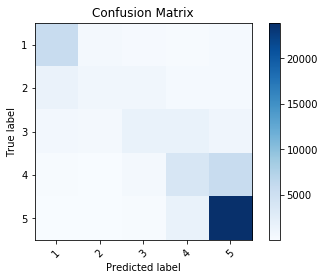

In [48]:
import matplotlib.pyplot as plt
classes = ['1', '2', '3', '4', '5']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

From the confusion matrix plot, I can see that it is easy to distinguish between 5 stars and 1 stars cases. However, it is hard to distinguish between 4 stars rate and 5 stars rate case. Also, it is not easy to distinguish between 1 stars and 2 stars cases. This is due to the unclear boundary in words. Client can use extremely positive words like 'perfect' to decribe reasons they give high rate. Vice visa.    
Learning lessons for Yelp business: I think instead of using 1,2,3,4 and 5 to rate restaurants. How about use binary choice like/dislike? Or even bad, average and good can help to classify the restaurants much clearer. Because the under expectation performance of machine learning model may indicates the unreasonable rating scores based on reviews. I think commen people can't tell the exact difference between 4 stars and 5 stars cases as well.

## Use PCA to reduce dimensionality for models

#### 1. Stardardize features

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(documents_train_vec)
X_test_standard = scaler.fit_transform(documents_test_vec) 

#### 2. Use PCA to transform data (train and test) and get princial components

In [9]:
from sklearn.decomposition import PCA
n_components = 100
pca_model = PCA(n_components = n_components)
X_train_pca = pca_model.fit_transform(X_train_standard)
X_test_pca = pca_model.transform(X_test_standard)

#### 3. Check how much (and how much percentage of) variance the principal components explain


In [10]:
pca_model.explained_variance_

array([7.41038689, 6.25745485, 4.74764816, 4.02395937, 3.98917515,
       3.63620251, 3.57085248, 3.47673034, 3.40297527, 3.26186054,
       3.125616  , 3.03797085, 3.00984853, 2.88297563, 2.84284085,
       2.75947182, 2.72113385, 2.70160127, 2.63914017, 2.59649634,
       2.56342007, 2.52957306, 2.51594613, 2.48741331, 2.43452592,
       2.40235157, 2.39757409, 2.36191023, 2.33930519, 2.31723343,
       2.27201349, 2.2612131 , 2.25511268, 2.24972426, 2.21876627,
       2.20118006, 2.17387514, 2.17088992, 2.15712999, 2.14232039,
       2.12947622, 2.10386364, 2.07394331, 2.06275763, 2.04601024,
       2.02931615, 2.02463575, 2.00781386, 2.0027959 , 1.98172016,
       1.97334393, 1.96370938, 1.96235132, 1.9455682 , 1.93017896,
       1.9208871 , 1.90687999, 1.90086239, 1.890958  , 1.88725857,
       1.87787051, 1.87510931, 1.866872  , 1.85034225, 1.84760888,
       1.83973679, 1.82872453, 1.82126602, 1.81334427, 1.79950719,
       1.79253029, 1.78231464, 1.77291104, 1.76784201, 1.76181

In [11]:
pca_model.explained_variance_ratio_

array([0.00148207, 0.00125148, 0.00094952, 0.00080479, 0.00079783,
       0.00072723, 0.00071416, 0.00069534, 0.00068059, 0.00065237,
       0.00062512, 0.00060759, 0.00060196, 0.00057659, 0.00056856,
       0.00055189, 0.00054422, 0.00054032, 0.00052782, 0.0005193 ,
       0.00051268, 0.00050591, 0.00050319, 0.00049748, 0.0004869 ,
       0.00048047, 0.00047951, 0.00047238, 0.00046786, 0.00046344,
       0.0004544 , 0.00045224, 0.00045102, 0.00044994, 0.00044375,
       0.00044023, 0.00043477, 0.00043417, 0.00043142, 0.00042846,
       0.00042589, 0.00042077, 0.00041479, 0.00041255, 0.0004092 ,
       0.00040586, 0.00040492, 0.00040156, 0.00040056, 0.00039634,
       0.00039467, 0.00039274, 0.00039247, 0.00038911, 0.00038603,
       0.00038417, 0.00038137, 0.00038017, 0.00037819, 0.00037745,
       0.00037557, 0.00037502, 0.00037337, 0.00037007, 0.00036952,
       0.00036794, 0.00036574, 0.00036425, 0.00036267, 0.0003599 ,
       0.0003585 , 0.00035646, 0.00035458, 0.00035357, 0.00035

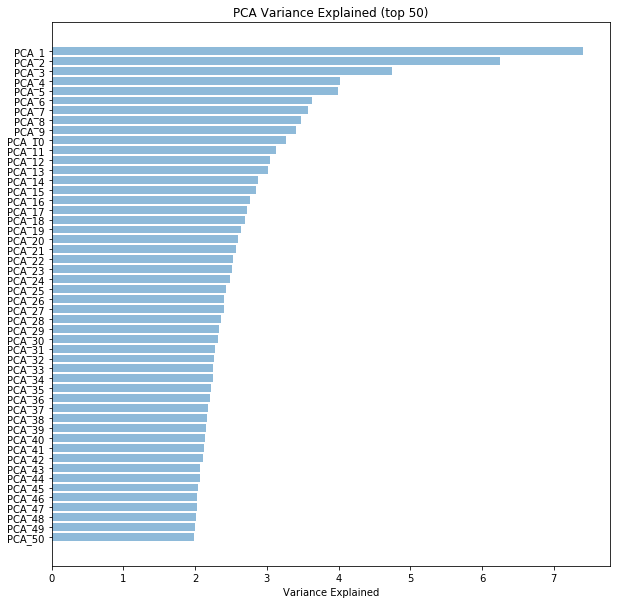

In [20]:
plt.figure(figsize=(10,10))
pca_range = np.arange(50) + 1
pca_names = ['PCA_%s' % i for i in pca_range]
y_pos = np.arange(len(pca_names))
plt.barh(y_pos, pca_model.explained_variance_[0:50], align='center', alpha = 0.5)
plt.yticks(y_pos, pca_names)
plt.xlabel('Variance Explained')
plt.title('PCA Variance Explained (top 50)')
plt.gca().invert_yaxis()

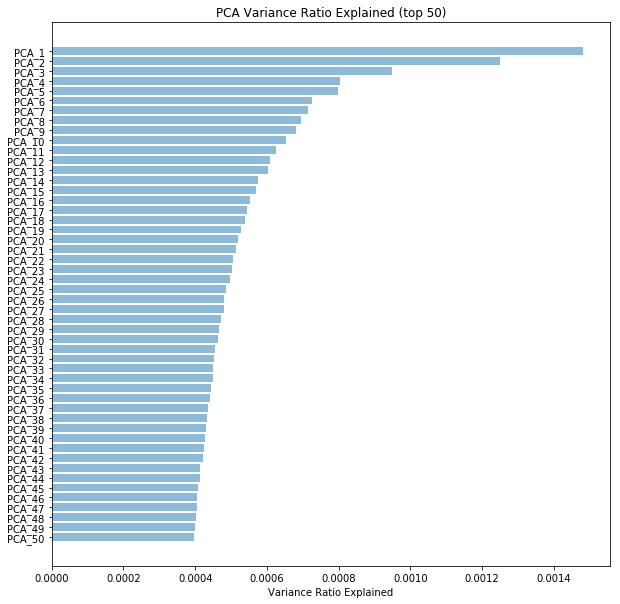

In [22]:
plt.figure(figsize=(10,10))
pca_range = np.arange(50) + 1
pca_names = ['PCA_%s' % i for i in pca_range]
y_pos = np.arange(len(pca_names))
plt.barh(y_pos, pca_model.explained_variance_ratio_[0:50], align='center', alpha = 0.5)
plt.yticks(y_pos, pca_names)
plt.xlabel('Variance Ratio Explained')
plt.title('PCA Variance Ratio Explained (top 50)')
plt.gca().invert_yaxis()

#### 4. Random Forest Classifier with PCA and Standarization

In [23]:
clf_RF_pca = RandomForestClassifier(n_estimators = 100,
                               max_depth = 25,
                               min_samples_split = 10,
                               min_samples_leaf = 10,
                               n_jobs= -1,
                               random_state = 1,
                               verbose = 0)
clf_RF_pca.fit(X_train_pca, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [25]:
print('The accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_RF_pca.score(X_train_pca, target_train), clf_RF_pca.score(X_test_pca, target_test)))


The accuracy score for train data set is 0.824211, for test data set is: 0.620326


#### 5. Logistic Regression Classifier with PCA and Standarization

In [26]:
clf_LR_pca = LogisticRegression(multi_class = 'ovr', n_jobs = -1, verbose = 1)
clf_LR_pca.fit(X_train_pca, target_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [27]:
print('The accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_LR_pca.score(X_train_pca, target_train), clf_LR_pca.score(X_test_pca, target_test)))


The accuracy score for train data set is 0.654612, for test data set is: 0.655086


#### 6. Use grid search to tune parameters for Logistic Regression model with PCA and Standarization.

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
gs_clf = LogisticRegression(multi_class = 'ovr', n_jobs = -1, verbose = 1)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.05, 0.1, 0.5, 1.0],
    'random_state': [1]
}
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(gs_clf, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train_pca, target_train)

clf_best = grid_obj.best_estimator_

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

In [29]:
print('The accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_best.score(X_train_pca, target_train), clf_best.score(X_test_pca, target_test)))


The accuracy score for train data set is 0.654498, for test data set is: 0.655503
